In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df_main = pd.read_csv('main_dataset.csv')

In [8]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   track_uri             277938 non-null  object 
 1   name                  277923 non-null  object 
 2   artists_names         277938 non-null  object 
 3   popularity            277938 non-null  int64  
 4   album_type            277938 non-null  object 
 5   is_playable           277938 non-null  bool   
 6   release_date          277938 non-null  object 
 7   artists_uris          277938 non-null  object 
 8   playlist_uris         277938 non-null  object 
 9   danceability          277938 non-null  float64
 10  energy                277938 non-null  float64
 11  key                   277938 non-null  float64
 12  loudness              277938 non-null  float64
 13  mode                  277938 non-null  float64
 14  speechiness           277938 non-null  float64
 15  

In [9]:
# df_moods = pd.read_csv('data_moods.csv')
df_moods = pd.read_csv('merged_moods_data.csv')
print(df_moods.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              2293 non-null   object 
 1   album             686 non-null    object 
 2   artist            2293 non-null   object 
 3   id                2293 non-null   object 
 4   release_date      686 non-null    object 
 5   popularity        686 non-null    float64
 6   length            2293 non-null   int64  
 7   danceability      2293 non-null   float64
 8   acousticness      2293 non-null   float64
 9   energy            2293 non-null   float64
 10  instrumentalness  2293 non-null   float64
 11  liveness          2293 non-null   float64
 12  valence           2293 non-null   float64
 13  loudness          2293 non-null   float64
 14  speechiness       2293 non-null   float64
 15  tempo             2293 non-null   float64
 16  key               686 non-null    float64


calm         935
happy        468
energetic    460
sad          430
Name: mood, dtype: int64


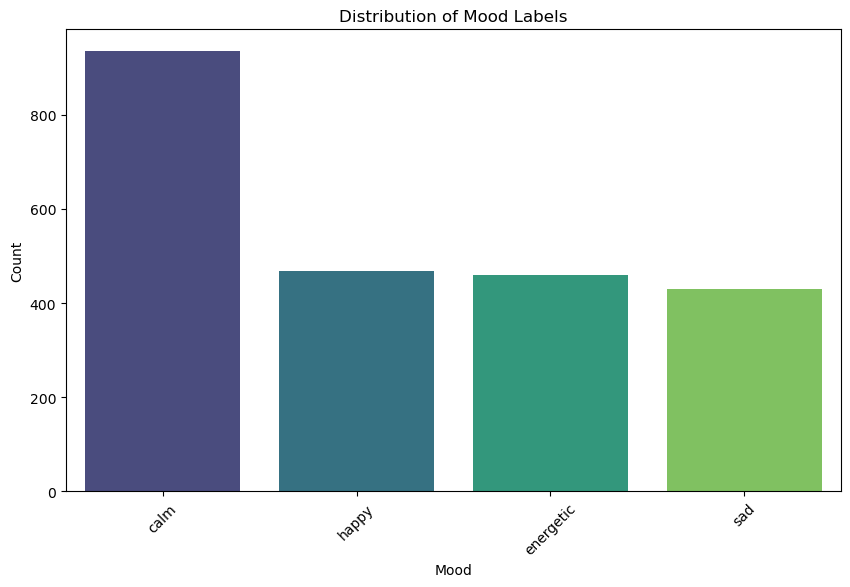

In [10]:
# Count the occurrences of each unique mood
mood_counts = df_moods['mood'].value_counts()
print(mood_counts)
# Plot the distribution of the 'mood' labels
plt.figure(figsize=(10, 6))  # You can adjust the size as needed
sns.barplot(x=mood_counts.index, y=mood_counts.values, palette='viridis')
plt.title('Distribution of Mood Labels')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.show()

In [19]:
file_path = 'data_moods.csv'
data_moods = pd.read_csv(file_path)
data_moods_cleaned = data_moods.dropna()
X = data_moods_cleaned.drop(columns=['name', 'length', 'album', 'artist', 'id', 'release_date', 'mood', 'key'])
y = data_moods_cleaned['mood']

# Encode the 'mood' labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict the moods on the testing set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print out the accuracy and detailed classification report
print(f'Accuracy: {accuracy*100:.2f}%')
print('Classification Report:')
print(classification_rep)


Accuracy: 81.16%
Classification Report:
              precision    recall  f1-score   support

        Calm       1.00      0.98      0.99        41
   Energetic       0.66      0.78      0.71        32
       Happy       0.50      0.40      0.44        25
         Sad       0.93      0.93      0.93        40

    accuracy                           0.81       138
   macro avg       0.77      0.77      0.77       138
weighted avg       0.81      0.81      0.81       138



## Modify main dataset to the labeled dataset format to being labeling process

TODO: CHECK WHAT'S UP WITH DURATION AND LENGHT

In [20]:
df1 = df_main
df2 = df_moods

# Step 1: Rename columns in df1 to match those in df2 where necessary
renames = {
    'track_uri': 'id', 
    'name': 'name', 
    'artists_names': 'artist',
    'release_date': 'release_date',
    'popularity': 'popularity',
    'danceability': 'danceability',
    'acousticness': 'acousticness',
    'energy': 'energy',
    'instrumentalness': 'instrumentalness',
    'liveness': 'liveness',
    'valence': 'valence',
    'loudness': 'loudness',
    'speechiness': 'speechiness',
    'tempo': 'tempo',
    'key': 'key',
    'time_signature': 'time_signature',
}

df1_transformed = df1.rename(columns=renames)

# Step 2: Drop columns in df1 that are not present in df2
columns_to_keep = list(renames.values())  # columns from df2 that we need to keep in df1
df1_transformed = df1_transformed[columns_to_keep]

# Step 3: Convert data types if necessary
# For example, if 'key' needs to be an int but is float in df1:
df1_transformed['key'] = df1_transformed['key'].astype(int)

# Step 4: Add any missing columns from df2 into df1_transformed, initialize with default or null values
# Example if 'mood' is missing:
df1_transformed['mood'] = 'Unknown'  # Or use None if you want to keep it as NaN

# Defining the correct order of columns as they appear in df2
correct_column_order = [
    'name', 'album', 'artist', 'id', 'release_date',
    'popularity', 'length', 'danceability', 'acousticness', 'energy',
    'instrumentalness', 'liveness', 'valence', 'loudness', 'speechiness',
    'tempo', 'key', 'time_signature', 'mood'
]

# We'll use 'Unknown' or a placeholder for columns that don't exist in df1_transformed.
# For example, if 'album' and 'length' are not present in df1_transformed, we can initialize them with default values.
# Since 'album' is of type object, it can be initialized with a string, and 'length' which seems to be related to duration can be derived or set to default if it does not exist.

# Checking if 'album' and 'length' (or any other missing columns) exist, if not, add them
for column in correct_column_order:
    if column not in df1_transformed.columns:
        if column == 'album':
            df1_transformed[column] = 'Unknown'  # or any other default value suitable for your dataset
        elif column == 'length':
            df1_transformed[column] = 0  # Assuming length is an integer, replace 0 with appropriate default value
        # Add similar conditions for other missing columns with suitable default values

# Now, reorder the DataFrame according to the structure of df2
df1_transformed = df1_transformed[correct_column_order]

# Finally, check the structure to ensure it's correct
print(df1_transformed.info())

# Check the final structure
print(df1_transformed.info())

# Check the structure of the df2 datset
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277938 entries, 0 to 277937
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              277923 non-null  object 
 1   album             277938 non-null  object 
 2   artist            277938 non-null  object 
 3   id                277938 non-null  object 
 4   release_date      277938 non-null  object 
 5   popularity        277938 non-null  int64  
 6   length            277938 non-null  int64  
 7   danceability      277938 non-null  float64
 8   acousticness      277938 non-null  float64
 9   energy            277938 non-null  float64
 10  instrumentalness  277938 non-null  float64
 11  liveness          277938 non-null  float64
 12  valence           277938 non-null  float64
 13  loudness          277938 non-null  float64
 14  speechiness       277938 non-null  float64
 15  tempo             277938 non-null  float64
 16  key               27

## Label the large dataset with our random forest classifier

In [22]:
# Load and prepare your original dataset
# Assuming df1_transformed is already loaded and prepared
X_df1 = df1_transformed.drop(columns=['name', 'length', 'album', 'artist', 'id', 'release_date', 'mood', 'key'])

# Predict the moods for df1_transformed
y_pred_df1 = rf_classifier.predict(X_df1)

# Decode the predicted labels back to original mood labels
predicted_moods = label_encoder.inverse_transform(y_pred_df1)

# Optionally, add the predicted mood labels back to df1_transformed for analysis or use
df1_transformed['mood'] = predicted_moods

In [24]:
# Output the first few rows to verify
df1_transformed[['name','artist','mood']].head(10)

,name,artist,mood
0,Way Up (feat. Ava Re),['Floduxe'],Happy
1,Fantasy - Felix Jaehn Remix,"['Alina Baraz', 'Galimatias']",Happy
2,Try Me,['DeJ Loaf'],Happy
3,Walk on by (Sound Remedy Remix),['Noosa'],Sad
4,Pretty Wings,"['Zak Waters', 'Pretty Sister']",Energetic
5,The Safety Dance - Video Version,['Men Without Hats'],Happy
6,Idle Hands,['EXGF'],Happy
7,Religion,['Tongues.'],Happy
8,Saskatoon,['Data Romance'],Sad
9,Whirlpool,['Sea Wolf'],Sad


In [30]:
df_sorted_by_popul = df1_transformed.sort_values('popularity', ascending=False)

df_out_test = df_sorted_by_popul[['name','artist','mood']].head(1000)
df_out_test.to_csv('out_test.csv', index=False)

In [31]:
df_out_test.head(20)

,name,artist,mood
261193,Flowers,['Miley Cyrus'],Happy
226293,"Shakira: Bzrp Music Sessions, Vol. 53","['Bizarrap', 'Shakira']",Happy
138524,TQG,['KAROL G'],Happy
274024,Boy's a liar Pt. 2,"['PinkPantheress', 'Ice Spice']",Happy
269682,Die For You - Remix,"['The Weeknd', 'Ariana Grande']",Happy
260639,Calm Down (with Selena Gomez),"['Rema', 'Selena Gomez']",Happy
266216,I'm Good (Blue),"['David Guetta', 'Bebe Rexha']",Energetic
269098,Here With Me,['d4vd'],Sad
109517,Anti-Hero,['Taylor Swift'],Happy
193140,La Bachata,['Manuel Turizo'],Happy


Happy        100914
Sad           92405
Energetic     43149
Calm          41470
Name: mood, dtype: int64


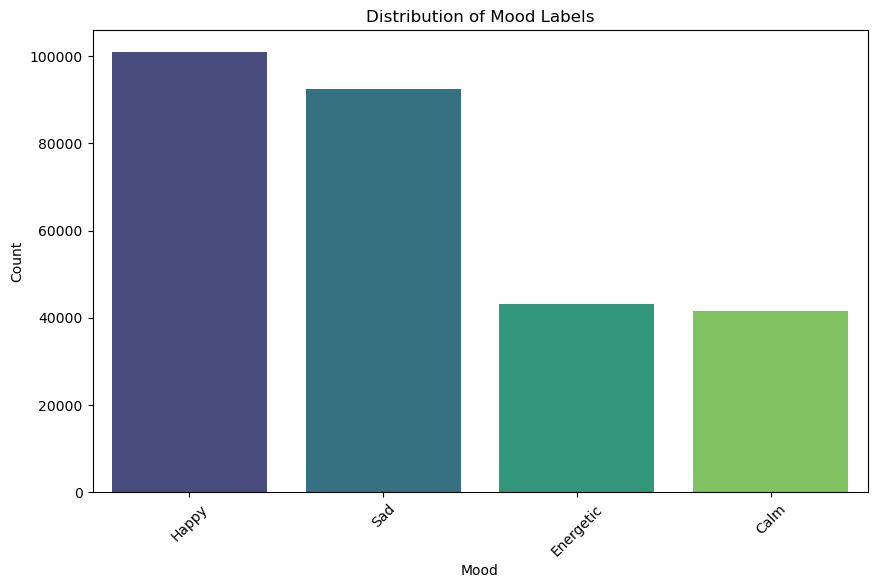

In [33]:
# Count the occurrences of each unique mood
mood_counts = df1_transformed['mood'].value_counts()
print(mood_counts)
# Plot the distribution of the 'mood' labels
plt.figure(figsize=(10, 6))  # You can adjust the size as needed
sns.barplot(x=mood_counts.index, y=mood_counts.values, palette='viridis')
plt.title('Distribution of Mood Labels')
plt.xlabel('Mood')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotates the labels on the x-axis for better readability
plt.show()